# Polars vs Pandas 

03 04 24

---

Comparing Polars and Pandas packages for loading and transforming data

In [1]:
import polars as pl
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from time import time

sns.set()
%matplotlib inline

## Load data

In [2]:
data_folder = '/Users/alexlee/Desktop/Data'
filename_gnaf = f'{data_folder}/geo/gnaf_feb2024/GNAF_CORE.psv'
filename_gnaf_parquet = f'{data_folder}/geo/gnaf_feb2024/GNAF_CORE.parquet'

In [3]:
gnaf = pd.read_csv(filename_gnaf, sep='|')
gnaf.shape

(15608317, 27)

## Queries

### Pandas

How many addresses for each street in postcode 3000?

In [4]:
# filter to postcode 3000
gnaf_melbourne = gnaf[gnaf['POSTCODE'] == 3000]

# count the number of addresses per street in postcode 3000
melbourne_street_counts = gnaf_melbourne.groupby('STREET_NAME').size()

# sort the data in descending order by the number of addresses
melbourne_street_counts.sort_values(ascending=False)

STREET_NAME
LONSDALE           11138
ABECKETT           10538
COLLINS            10066
LITTLE LONSDALE     9718
LA TROBE            7462
                   ...  
RUTLEDGE               1
HEAPE                  1
HARWOOD                1
RACING CLUB            1
DOMAIN                 1
Length: 165, dtype: int64

In [5]:
gnaf.query('POSTCODE == 3000').groupby('STREET_NAME').size().sort_values(ascending=False)

STREET_NAME
LONSDALE           11138
ABECKETT           10538
COLLINS            10066
LITTLE LONSDALE     9718
LA TROBE            7462
                   ...  
RUTLEDGE               1
HEAPE                  1
HARWOOD                1
RACING CLUB            1
DOMAIN                 1
Length: 165, dtype: int64

In [6]:
(
    gnaf
    .query('POSTCODE == 3000')
    .groupby('STREET_NAME')
    .size()
    .sort_values(ascending=False)
)

STREET_NAME
LONSDALE           11138
ABECKETT           10538
COLLINS            10066
LITTLE LONSDALE     9718
LA TROBE            7462
                   ...  
RUTLEDGE               1
HEAPE                  1
HARWOOD                1
RACING CLUB            1
DOMAIN                 1
Length: 165, dtype: int64

What is the distribution of starting letters for streets in NSW?

In [7]:
(
    gnaf
    .query('STATE == "NSW"')
    .STREET_NAME
    .str.slice(0, 1)
    .value_counts()
)

STREET_NAME
B    500267
C    467428
M    426049
S    326787
P    299393
W    296203
H    258910
G    250268
A    220864
R    217310
T    213359
L    196466
D    181450
K    167153
F    161510
E    143570
N    121485
O    119007
J     86372
V     68137
I     37394
Y     36899
Q     26382
U     22352
Z      2993
X       123
4        21
Name: count, dtype: int64

### Polars

In [8]:
gnaf = pl.read_csv(filename_gnaf, separator='|', infer_schema_length=10000)
gnaf.shape

(15608317, 27)

In [9]:
(
    gnaf
    .filter(pl.col("POSTCODE") == 3000)
    .group_by("STREET_NAME")
    .len()
    .sort('len', descending=True)
)

STREET_NAME,len
str,u32
"""LONSDALE""",11138
"""ABECKETT""",10538
"""COLLINS""",10066
"""LITTLE LONSDAL…",9718
"""LA TROBE""",7462
…,…
"""WELLINGTON""",1
"""RUTLEDGE""",1
"""ACDC""",1


In [10]:
(
    gnaf
    .filter(pl.col('STATE') == "NSW")
    .select(pl.col("STREET_NAME"))
    .with_columns(pl.col("STREET_NAME").str.slice(0, 1).alias("letter"))
    .group_by('letter')
    .count()
    .sort('count', descending=True)
)

/var/folders/7h/4cq59zrd6vb2jqwxh3wdk3nw0000gn/T/ipykernel_2994/1041641723.py:7: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  .count()


letter,count
str,u32
"""B""",500267
"""C""",467428
"""M""",426049
"""S""",326787
"""P""",299393
…,…
"""Q""",26382
"""U""",22352
"""Z""",2993


## Speed comparison

Loading data in Polars vs Pandas

In [11]:
# polars
t1 = time()
gnaf = pl.read_csv(filename_gnaf, separator='|', infer_schema_length=10000)
t2 = time()
print(t2-t1)

# pandas
t1 = time()
gnaf = pd.read_csv(filename_gnaf, sep='|')
t2 = time()
print(t2-t1)

4.853427886962891
39.20191216468811


In [12]:
gnaf_polars = pl.read_csv(filename_gnaf, separator='|', infer_schema_length=10000)
gnaf_pandas = pd.read_csv(filename_gnaf, sep='|')

Comparing the speed of some simple queries

In [13]:
# polars
t1 = time()
(
    gnaf_polars
    .filter(pl.col('STATE') == "NSW")
    .select(pl.col("STREET_NAME"))
    .with_columns(pl.col("STREET_NAME").str.slice(0, 1).alias("letter"))
    .group_by('letter')
    .count()
    .sort('count', descending=True)
)
t2 = time()
print(t2-t1)

# pandas
t1 = time()
(
    gnaf_pandas
    .query('STATE == "NSW"')
    .STREET_NAME
    .str.slice(0, 1)
    .value_counts()
)
t2 = time()
print(t2-t1)

/var/folders/7h/4cq59zrd6vb2jqwxh3wdk3nw0000gn/T/ipykernel_2994/2471861764.py:9: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  .count()


3.8098649978637695
3.2129640579223633


In [14]:
# polars
t1 = time()
(
    gnaf_polars
    .filter(pl.col("POSTCODE") == 3000)
    .group_by("STREET_NAME")
    .len()
    .sort('len', descending=True)
)
t2 = time()
print(t2 - t1)

# pandas
t1 = time()
results = (
    gnaf_pandas
    .query('POSTCODE == 3000')
    .groupby('STREET_NAME')
    .size()
    .sort_values(ascending=False)
)
t2 = time()
print(t2-t1)

2.3313450813293457
1.1500351428985596


## Loading parquet files

In [15]:
# load in pandas
t1 = time()
gnaf = pd.read_parquet(filename_gnaf_parquet)
t2 = time()
print(t2-t1)

# load in polars
t1 = time()
gnaf = pl.read_parquet(filename_gnaf_parquet)
t2 = time()
print(t2-t1)

26.306514978408813
16.54242491722107


## Lazy evaluation

In [16]:
gnaf = pl.scan_parquet(filename_gnaf_parquet)
t1 = time()
(
    gnaf
    .filter(pl.col("POSTCODE") == 3000)
    .group_by("STREET_NAME")
    .len()
    .sort('len', descending=True)
    .collect()
)
t2 = time()
print(t2 - t1)

0.11325383186340332


In [17]:
t1 = time()
(
    gnaf
    .filter(pl.col('STATE') == "NSW")
    .select(pl.col("STREET_NAME"))
    .with_columns(pl.col("STREET_NAME").str.slice(0, 1).alias("letter"))
    .group_by('letter')
    .len()
    .sort('len', descending=True)
    .collect()
)
t2 = time()
print(t2-t1)

0.19588303565979004


## Larger than memory datasets

In [ ]:
from os import listdir

In [166]:
nyc_folder = '/Users/alexlee/Desktop/Data'

filenames_nyc = f'{data_folder}/test_data/nyc_taxi'

In [167]:
all_files = listdir(filenames_nyc)

In [168]:
all_files = sorted(all_files)

In [ ]:
# column names of 2023 data so that they match the previous years
for filename in all_files[-11:]:
    print(filename)
    nyc_data = pl.read_parquet(f'{filenames_nyc}/{filename}').rename({'Airport_fee': 'airport_fee'})
    nyc_data.write_parquet(f'{filenames_nyc}/{filename}')

In [232]:
# consider only data from 2011 as the format changed

# ensure that the columns of all files are the data types
# probably not the best way of doing this
for filename in all_files:
    nyc_data = pl.scan_parquet(f'{filenames_nyc}/{filename}')
    nyc_data.select(
        pl.col('VendorID').cast(pl.Int64),
        pl.col('tpep_pickup_datetime').cast(pl.Datetime),
        pl.col('tpep_dropoff_datetime').cast(pl.Datetime),
        pl.col('passenger_count').cast(pl.Int64),
        pl.col('trip_distance').cast(pl.Float64),
        pl.col('RatecodeID').cast(pl.Int64),
        pl.col('store_and_fwd_flag').cast(pl.String),
        pl.col('PULocationID').cast(pl.Int64),
        pl.col('DOLocationID').cast(pl.Int64),
        pl.col('payment_type').cast(pl.Int64),
        pl.col('fare_amount').cast(pl.Float64),
        pl.col('extra').cast(pl.Float64),
        pl.col('mta_tax').cast(pl.Float64),
        pl.col('tip_amount').cast(pl.Float64),
        pl.col('tolls_amount').cast(pl.Float64),
        pl.col('improvement_surcharge').cast(pl.Float64),
        pl.col('total_amount').cast(pl.Float64),
        pl.col('congestion_surcharge').cast(pl.Float64),
        pl.col('airport_fee').cast(pl.Float64)
    ).collect().write_parquet(f'{filenames_nyc}/{filename}')

In [233]:
# load the data folder
nyc_taxis = pl.scan_parquet(f'{filenames_nyc}/*.parquet')

In [242]:
# how many rows in the data?
nyc_taxis.select(pl.len()).collect()

len
u32
1397171103


In [247]:
# what is the max fare?
nyc_taxis.select(pl.max('fare_amount')).collect()

fare_amount
f64
998310.03


In [250]:
# what is the average fare?
nyc_taxis.select(pl.mean('fare_amount')).collect()

fare_amount
f64
12.433398


In [251]:
# what is the median fare?
nyc_taxis.select(pl.median('fare_amount')).collect()

fare_amount
f64
9.0


In [254]:
# what is the distribution of passenger counts?
nyc_taxis.group_by('passenger_count').len().sort('len', descending=True).collect().head(10)

passenger_count,len
i64,u32
1,981235169
2,201096537
5,74997895
3,58829131
6,38145225
4,28369915
0,9021642
null,5469148
7,2438


In [255]:
nyc_taxis.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee']

In [256]:
# how many different pickup locations are there?
nyc_taxis.group_by('PULocationID').len().collect()

PULocationID,len
i64,u32
140,23757796
161,50241528
6,6851
146,1590748
30,887
…,…
232,2785351
229,27277422
238,24580042


In [299]:
# let's see how people are paying over time
payment_types_year = (
    nyc_taxis
    .with_columns(pl.col('tpep_pickup_datetime').dt.year().alias('pickup_year'))
    .group_by(pl.col(['pickup_year', 'payment_type']))
    .len()
    .filter(pl.col('pickup_year').is_in(list(range(2011,2024))))
    .filter(pl.col('payment_type').is_in([1,2]))
    .sort(pl.col('pickup_year'))
    .collect()
)

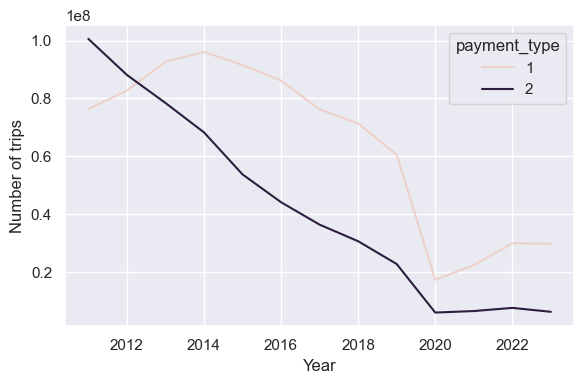

In [301]:
plt.figure(figsize=(6, 4))
sns.lineplot(data=payment_types_year.to_pandas(), x='pickup_year', y='len', hue='payment_type')
plt.xlabel('Year')
plt.ylabel('Number of trips')
plt.tight_layout()
plt.savefig('payments_over_time_nyc_taxis.png')